# Installing Dependencies

In [1]:
pip_list = !pip list
packages = ["chardet", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "spacy", "statsmodels", "tensorflow"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


# Importing Libraries

In [2]:
import calendar
import datetime
import os
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4636644464645988899
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16149905408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15748417876510237250
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
0
MemTotal:       16390844 kB
0
Mon Apr  3 05:10:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. 

# Connecting to SQL

In [3]:
try:
    conn = mysql.connector.connect(
        user="user",
        password=os.environ["SQL_CONN_STRING"],
        host="mysqlserver.mysql.database.azure.com",
        port=3306,
        database="",
        ssl_ca="{ca-cert filename}",
        ssl_disabled=False,
    )
    print("Connection established")

except mysql.connector.Error as e:
    if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with the user name or password")
    elif e.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(e)
else:
    tables = {table: pd.read_sql(f"""SELECT * FROM {table};""", conn) for table in pd.read_sql("SHOW TABLES", conn).iloc[:, 0]}
    for table_name, table_dataframe in tables.items():
        print(f"-------------------------------------------------------\nTable: {table_name}")
        display(table_dataframe)
    conn.close()
    print(f"Discovered table(s): {len(tables)}.\nDB Connection closed.")

# Displaying DataFrame

In [4]:
display(df)

,text,HOF
0,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,Non-Hateful
1,@Newsweek Are you freaking crazy????[NEWLINE]I...,Non-Hateful
2,Undecided voters (and MAGATs alike);[NEWLINE]I...,Non-Hateful
3,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,Non-Hateful
4,@CNN Nancy Pelosi and the Dems wont do a deal ...,Non-Hateful
...,...,...
2995,@JoeBiden Stay healthy Mr Vice President! You ...,Non-Hateful
2996,@TheRock @JoeBiden @KamalaHarris Bye bye Rock!...,Non-Hateful
2997,Countless and effortless. [NEWLINE][NEWLINE]Th...,Non-Hateful
2998,The only thing Trump ran well was his business...,Non-Hateful


# Defining Parameters

In [5]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 50
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
TOP_WORDS = 10_000
EMBED_DIM = 128
NLP = 1
CLASSIFICATION = 1

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
x_label = "text"
y_label = "HOF"

-------------------------------------------------------
Current Shape: (3000, 2).
-------------------------------------------------------
Duplicates Percentage: 0.03%
Duplicates have been removed (2999, 2).


,text,HOF
465,Which team do you want to be on ⁉️ [NEWLINE][N...,Non-Hateful
821,Remember When Donald Trump Told Biden He’ll Ha...,Non-Hateful
1493,Twitter celebrates dogs coming back to the Whi...,Non-Hateful


# Mapping Target Values

In [6]:
df.dropna(subset=[y_label], axis=0, inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
df[y_label], y_index = df[y_label].factorize()
print(f"y_index: {[[i, y] for i, y in enumerate(y_index)]}")
display(df[y_label].value_counts().to_frame().rename({y_label: "Count"}, axis=1))

-------------------------------------------------------
Dropping null target values.
Current Shape: (2999, 2).
-------------------------------------------------------
y_index: [[0, 'Non-Hateful'], [1, 'Hateful']]


,Count
0,2648
1,351


# Correlation Matrix

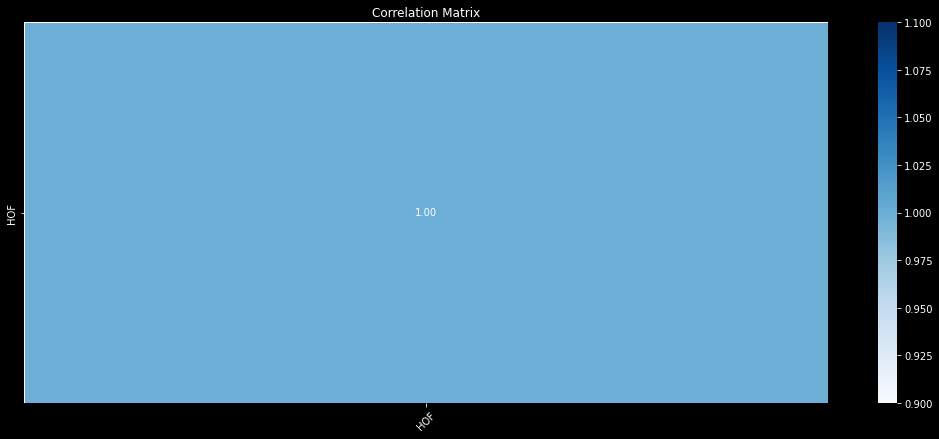

In [7]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

In [8]:
corr_matrix = df.corr()[y_label].sort_values().drop(y_label)
if corr_matrix.shape[0]:
    sns.barplot(x=corr_matrix.values, y=corr_matrix.index).set_title("Correlation Matrix")
    plt.show()

In [9]:
corr_matrix = df.corr()[y_label].abs().sort_values(ascending=False).drop(y_label)
if corr_matrix.shape[0]:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=ax[0]).set_title("Horizontal Correlation Matrix")
    sns.barplot(x=corr_matrix.index, y=corr_matrix.values, ax=ax[1]).set_title("Vertical Correlation Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Eliminating Multicollinearity between Features

In [10]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr

col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")

-------------------------------------------------------
Current Shape: (2999, 2).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


# Checking NULL Values

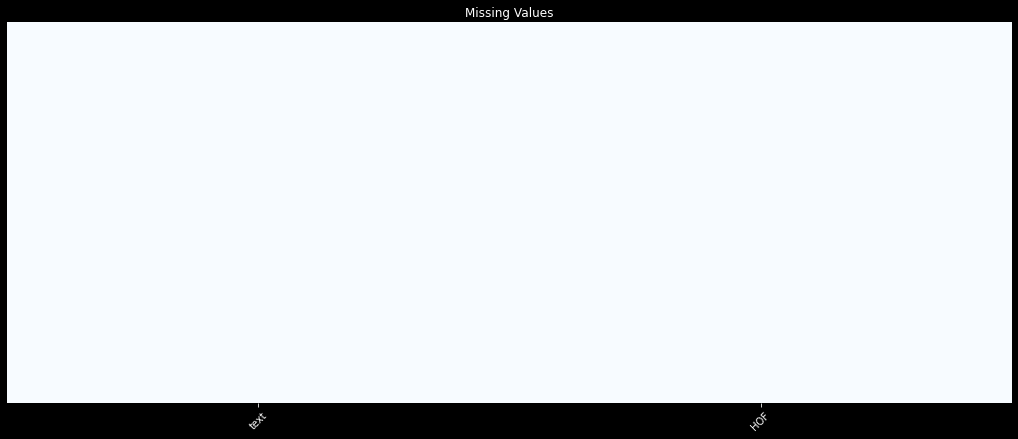

In [11]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()

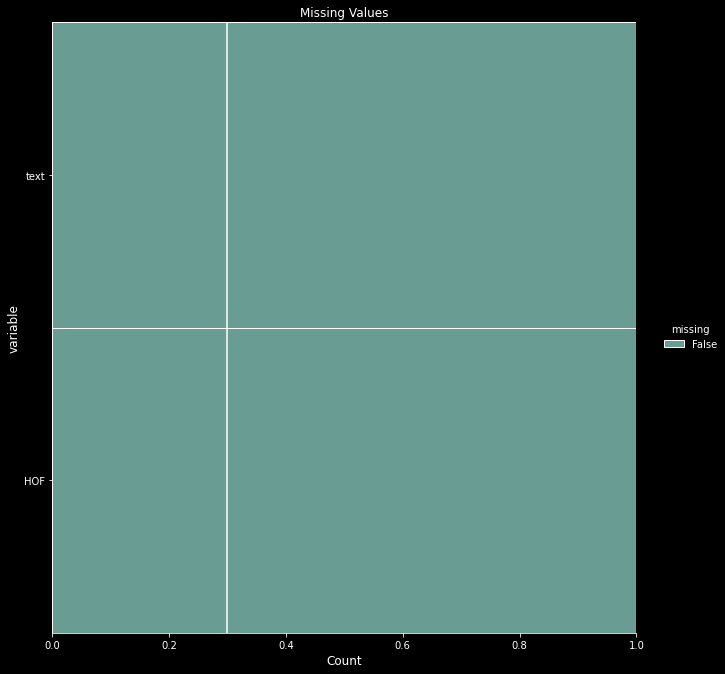

In [12]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

# Feature Description

In [13]:
col_cat_cv = [x_label]
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0) and col != y_label and col not in col_cat_cv]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col != y_label]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe + col_cat_cv]
col_num_disc = [col for col in col_num if df[col].nunique() <= 10]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_cat_cv ({len(col_cat_cv)}): {col_cat_cv}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_cat_cv) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,text,object,0,0%,n/a,n/a,n/a,n/a,n/a,2999,[@SukiRavan @ProgressPotato @MarkZuckerb0rg @J...
1,HOF,int64,0,0%,n/a,n/a,n/a,n/a,n/a,2,"[0, 1]"


Current Shape: (2999, 2).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_cat_cv (1): ['text']
col_num_disc (0): []
col_num_cont (0): []
-------------------------------------------------------
total cols for preprocessor: 1


# Frequency Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [14]:
for col in col_cat_ohe:
    sr_temp = df.groupby(col)[y_label].count() / df.shape[0]
    df_temp = sr_temp[sr_temp > 0.01].index
    df[col] = np.where(df[col].isin(df_temp), df[col], "-")

# Count Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [15]:
MAX_COLS = 100
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    # df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass

,count,unique,top,freq
text,2999,2999,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JSiffordson @KyleKulinski If Joe Biden is .00000000000000001 % better I will vote for him.,1


# Countplot for Categorical Feature(s)

In [16]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.countplot(x=df[col], ax=ax[0], hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[1].pie(x=df[col].value_counts(), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

# Distplot for Discrete Numeric Feature(s)

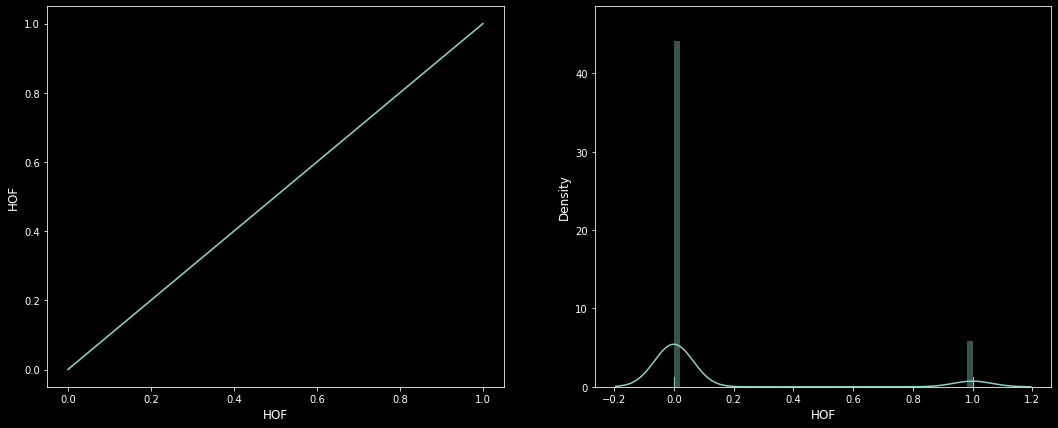

In [17]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

# Detecting Outliers

In [18]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": [],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [col for col in col_num_cont + ([] if CLASSIFICATION else [y_label]) if col in cols]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
                df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = (1 / df[col])
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = (df[col] ** 0.5)
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = (df[col] ** (1/1.2))
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

-------------------------------------------------------
Performing keep transformation on cols ['text', 'HOF'].
Current Shape: (2999, 2).
-------------------------------------------------------
Scanning for outliers in [].
Outliers Percentage: 0.00%
-------------------------------------------------------
upper_range:
Series([], dtype: float64)
-------------------------------------------------------
lower_range:
Series([], dtype: float64)
-------------------------------------------------------
Outliers have been kept (2999, 2).





# Standard Distribution and Interquantile Range

In [19]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
HOF,2999.00,0.12,0.32,0.00,0.00,0.00,0.00,1.00


,0.01,0.99
HOF,0.00,1.00


# Preprocessing NLP

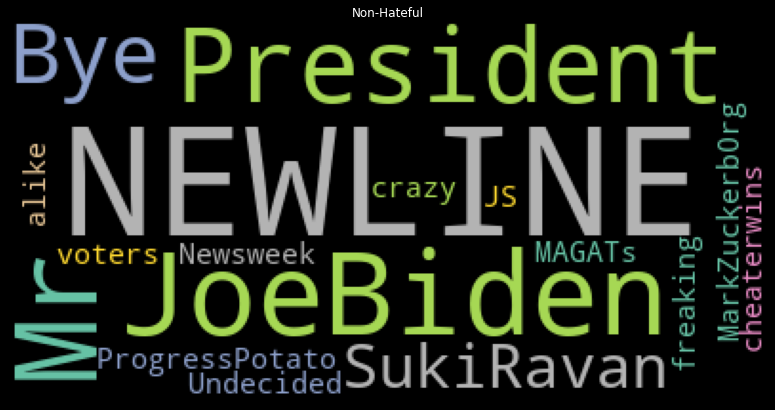

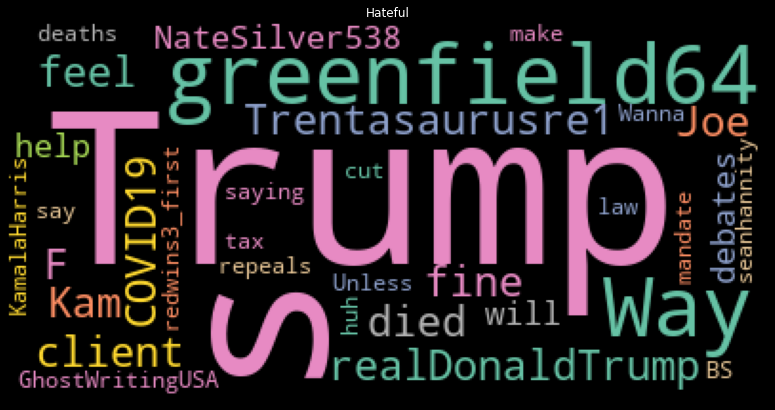

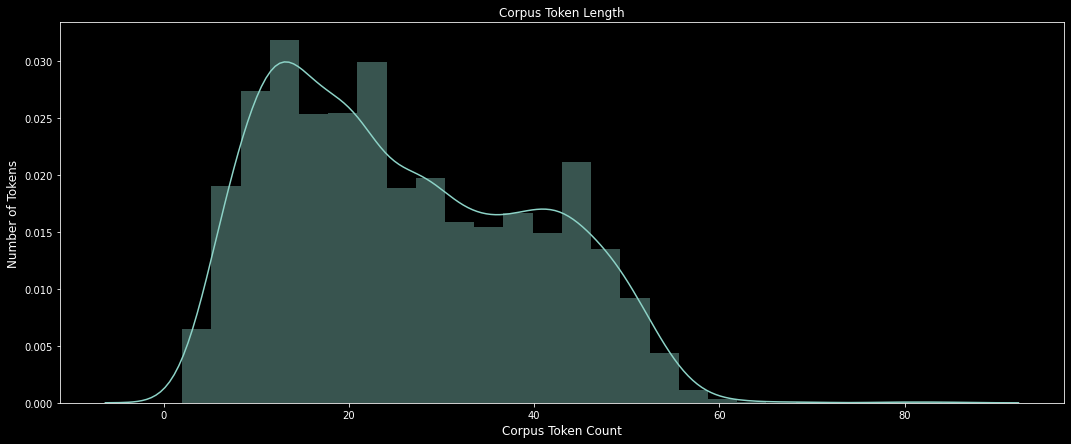

In [20]:
if len(col_cat_cv):
    import re
    import spacy
    from wordcloud import WordCloud

    nlp = spacy.load(
        "en_core_web_lg" if NLP else "en_core_web_trf", disable=["ner", "parser"]
    )    
    for label in df[y_label].unique():
        fig, ax = plt.subplots(nrows=1, ncols=1)
        wordcloud = WordCloud(min_font_size=10, max_words=100, background_color="black", colormap="Set2", collocations=False).generate(str(df[df[y_label]==label][next(iter(col_cat_cv))]))
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.title.set_text(y_index[label])
        plt.show()
    
    sns.distplot(x=[len(token) for token in df[x_label].apply(lambda text: text.split())])
    plt.title("Corpus Token Length")
    plt.xlabel("Corpus Token Count")
    plt.ylabel("Number of Tokens")


def word_tokenizer(row):
    token = [
        token.lemma_.strip()
        for token in nlp(re.sub(r"@\w+|#\w+", "", row))
        if not token.is_punct
        and not token.is_stop
        and not token.like_email
        and not token.like_num
        and not token.like_url
    ]
    return token if token else ["."]


def word_vectorizer(X_series):
    return np.concatenate(
        [
            arr
            for arr in X_series.apply(
                lambda row: nlp(" ".join(word_tokenizer(row.lower()))).vector
                if NLP
                else nlp(" ".join(word_tokenizer(row.lower())))._.trf_data.tensors[-1],
            )
        ]
    ).reshape(-1, [768, 300][NLP])

# Balancing the Sample Size

In [21]:
min_sample_size = df[y_label].value_counts().min()
df = pd.concat([df[df[y_label] == val].sample(min_sample_size) for val in df[y_label].unique()], ignore_index=True)

# Feature Engineering and Data Pipeline (Impute, OHE, Scaling, Variance Threshold, PCA)

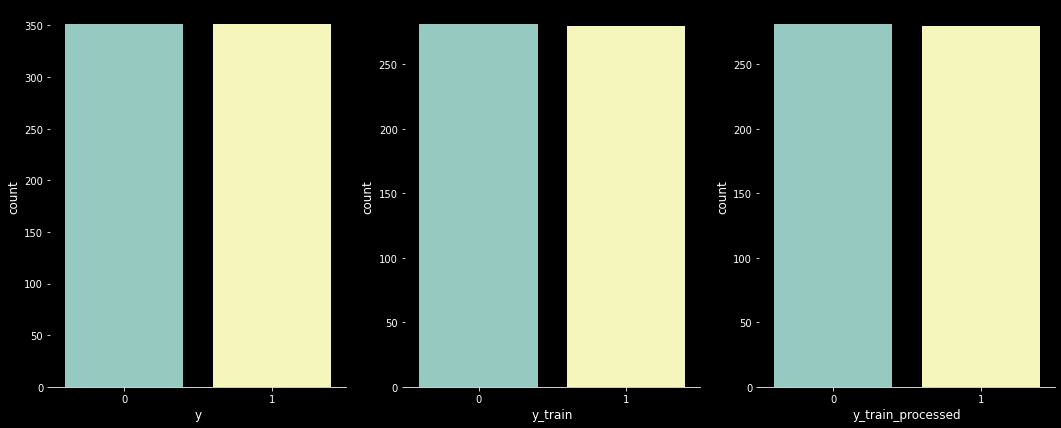

-------------------------------------------------------
class_weights: {0: 0.998220640569395, 1: 1.0017857142857143}
-------------------------------------------------------
y:
0   0.50
1   0.50
Name: HOF, dtype: float64
-------------------------------------------------------
y_train:
0   0.50
1   0.50
Name: HOF, dtype: float64
-------------------------------------------------------
y_train_processed:
0   0.50
1   0.50
Name: HOF, dtype: float64
-------------------------------------------------------
y_test:
1   0.50
0   0.50
Name: HOF, dtype: float64
-------------------------------------------------------
y_test_processed:
1   0.50
0   0.50
Name: HOF, dtype: float64
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_num_disc (0): []
col_num_cont (0): []
-------------------------------------------------------
total cols for preprocessor: 0
-------------------------------------------------------
X: (702, 1)	X_train: (561, 1)	X_train_processe

In [22]:
%%time
X, y = df.drop(y_label, axis=1), df[y_label]
if NLP == 4:
    tokenizer = keras.preprocessing.text.Tokenizer(num_words=TOP_WORDS, split=" ")
    tokenizer.fit_on_texts(X.values.reshape(-1,))
    X = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X.values.reshape(-1,)))
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
preprocessor_cat_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)),
)
preprocessor_cat_cv = make_pipeline(
    [
        (FunctionTransformer(word_vectorizer)),
        (FunctionTransformer(word_vectorizer)),
        (TfidfVectorizer(tokenizer=word_tokenizer, ngram_range=[1, 1])),
        (CountVectorizer(tokenizer=word_tokenizer, ngram_range=[1, 1])),
    ][min(NLP, 3)]
)
preprocessor_num_disc = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_num_cont = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_col = make_column_transformer(
    (preprocessor_cat_oe, col_cat_oe),
    (preprocessor_cat_ohe, col_cat_ohe),
    (preprocessor_cat_cv, next(iter(col_cat_cv)) if len(col_cat_cv) else []),
    (preprocessor_num_disc, col_num_disc),
    (preprocessor_num_cont, col_num_cont),
    sparse_threshold=0
)
preprocessor = make_pipeline(
    (preprocessor_col),
)
X_train_processed, y_train_processed = X_train if NLP == 4 else preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = X_test if NLP == 4 else  preprocessor.transform(X_test), y_test
if CLASSIFICATION:
    class_weights = {i: w for i, w in enumerate(class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_processed), y=y_train_processed))}
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0]).set_xlabel("y")
    sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2]).set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"class_weights: {class_weights}")
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

# Building, Hyper-param Tuning ML and ANN Models

In [23]:
def tune_dl_model(hp):
    model = keras.models.Sequential()
    if NLP == 4:    
        model.add(keras.layers.Embedding(TOP_WORDS, EMBED_DIM, input_length=X_train_processed.shape[1]))
        model.add(keras.layers.LSTM(100, dropout=0.25, recurrent_dropout=0.25))
        model.add(keras.layers.Dense(50, activation="relu"))
        model.add(keras.layers.Dense(25, activation="relu"))
    else:
        model.add(
            keras.layers.Dense(
                units=hp.Int("input_00_unit", min_value=32, max_value=512, step=32),
                input_shape=X_train_processed.shape[1:],
            )
        )
        for i in range(hp.Int("num_layers", min_value=1, max_value=64)):
            model.add(
                keras.layers.Dense(
                    units=hp.Int(f"hidden_{i:02}_unit", min_value=32, max_value=512, step=32),
                    activation="relu",
                )
            )
            model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    val_per_epoch = history.history[
        ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
    ]
    best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()

    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test_processed,
            [
                model.predict(X_test_processed).round(),
                np.argmax(model.predict(X_test_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train_processed,
            [
                model.predict(X_train_processed).round(),
                np.argmax(model.predict(X_train_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train_processed, model.predict(X_train_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_train_processed, model.predict(X_train_processed)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 4, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 4, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_train_processed).T[0],
                    "Residuals": model.predict(X_train_processed).T[0] - y_train_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_test_processed).T[0],
                    "Residuals": model.predict(X_test_processed).T[0] - y_test_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()
        
        plt.subplot(1, 4, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title(
            "Error Terms",
            fontsize=10,
        )
        plt.xlabel("Errors")
        plt.grid()

        plt.subplot(1, 4, 4)
        sns.distplot(y_train_processed, hist=False, color="darkorange", label="Truth")
        sns.distplot(model.predict(X_train_processed).T[0], hist=False, color="darkcyan", label="Predicted",)
        plt.title("Truth vs Predicted", fontsize=10,)
        plt.xlabel(y_label)
        plt.legend()
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Building Neural Network Model

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.48672565817832947

Best val_accuracy So Far: 0.7345132827758789
Total elapsed time: 00h 01m 21s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
input_00_unit: 256
num_layers: 8
hidden_00_unit: 448
dropout: 0.1
learning_rate: 0.001
hidden_01_unit: 256
hidden_02_unit: 320
hidden_03_unit: 352
hidden_04_unit: 448
hidden_05_unit: 160
hidden_06_unit: 64
hidden_07_unit: 288
hidden_08_unit: 448
hidden_09_unit: 512
hidden_10_unit: 64
hidden_11_unit: 480
hidden_12_unit: 128
hidden_13_unit: 224
hidden_14_unit: 64
hidden_15_unit: 192
hidden_16_unit: 352
hidden_17_unit: 352
hidden_18_unit: 320
hidden_19_unit: 384
hidden_20_unit: 352
hidden_21_unit: 32
hidden_22_unit: 320
hidden_23_unit: 352
hidden_24_unit: 64
hidden_25_unit: 224
hidden_26_unit: 128
hidden_27_unit: 352
hidden_28_unit: 320
hidden_29_unit: 352
hidden_30_unit: 416
hidden_31_unit: 352
hidden_32_unit: 480
hidden_33_unit: 480
hidden_34_unit: 448

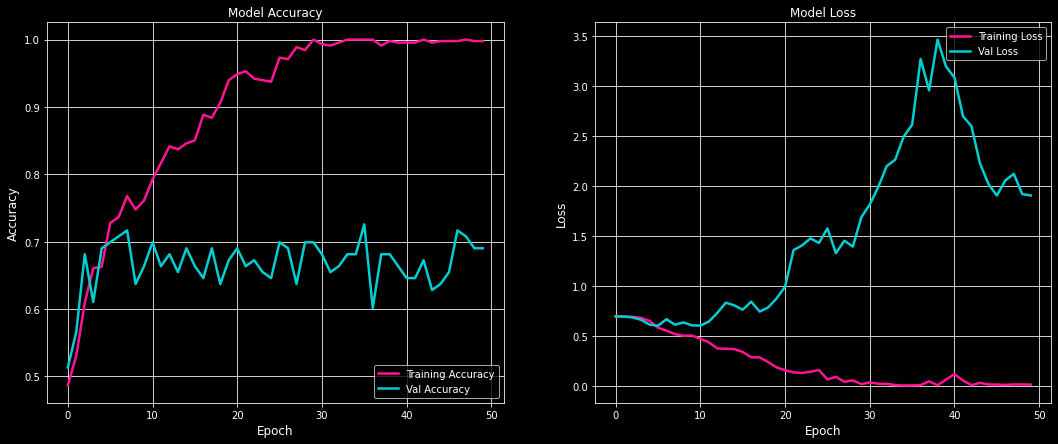

Best epoch: 36
Epoch 1/36
2/2 [==============================] - 1s 185ms/step - loss: 0.6933 - accuracy: 0.4643 - val_loss: 0.6908 - val_accuracy: 0.6283
Epoch 2/36
2/2 [==============================] - 0s 22ms/step - loss: 0.6909 - accuracy: 0.5335 - val_loss: 0.6875 - val_accuracy: 0.4956
Epoch 3/36
2/2 [==============================] - 0s 20ms/step - loss: 0.6820 - accuracy: 0.5179 - val_loss: 0.6681 - val_accuracy: 0.6637
Epoch 4/36
2/2 [==============================] - 0s 20ms/step - loss: 0.6572 - accuracy: 0.6875 - val_loss: 0.6277 - val_accuracy: 0.6991
Epoch 5/36
2/2 [==============================] - 0s 38ms/step - loss: 0.6408 - accuracy: 0.6741 - val_loss: 0.6103 - val_accuracy: 0.6903
Epoch 6/36
2/2 [==============================] - 0s 39ms/step - loss: 0.6018 - accuracy: 0.7054 - val_loss: 0.5854 - val_accuracy: 0.6991
Epoch 7/36
2/2 [==============================] - 0s 20ms/step - loss: 0.5496 - accuracy: 0.7321 - val_loss: 0.6162 - val_accuracy: 0.7080
Epoch 8/36


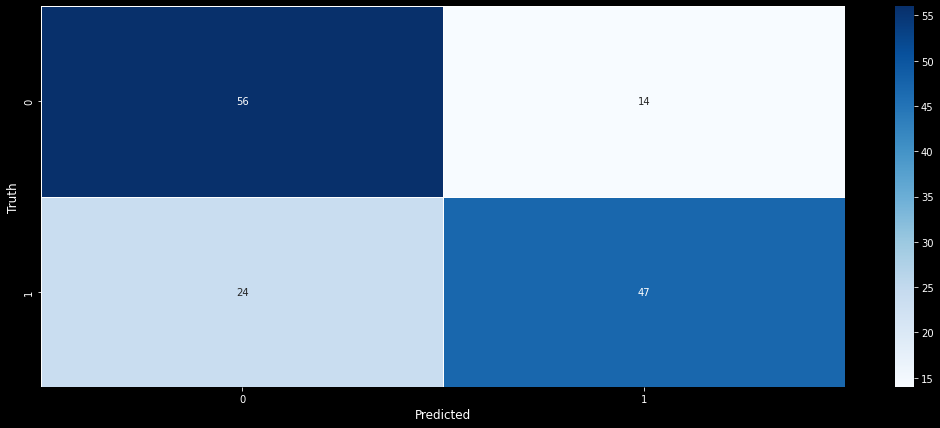

,Truth,Predicted
0,1,1.00
1,1,1.00
2,0,1.00
3,0,1.00
4,1,0.00
5,0,0.00
6,1,1.00
7,1,0.00
8,0,0.00
9,0,0.00


CPU times: user 1min 23s, sys: 2.36 s, total: 1min 25s
Wall time: 1min 28s


In [24]:
%%time
OVERSAMPLE = 0
dl_model = build_dl_model(*train_dl_model())

# Saving the Model for Deployment

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_39 (Dense)             (None, 448)               115136    
_________________________________________________________________
dropout_34 (Dropout)         (None, 448)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               114944    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 320)               82240     
_________________________________________________________________
dropout_36 (Dropout)         (None, 320)              

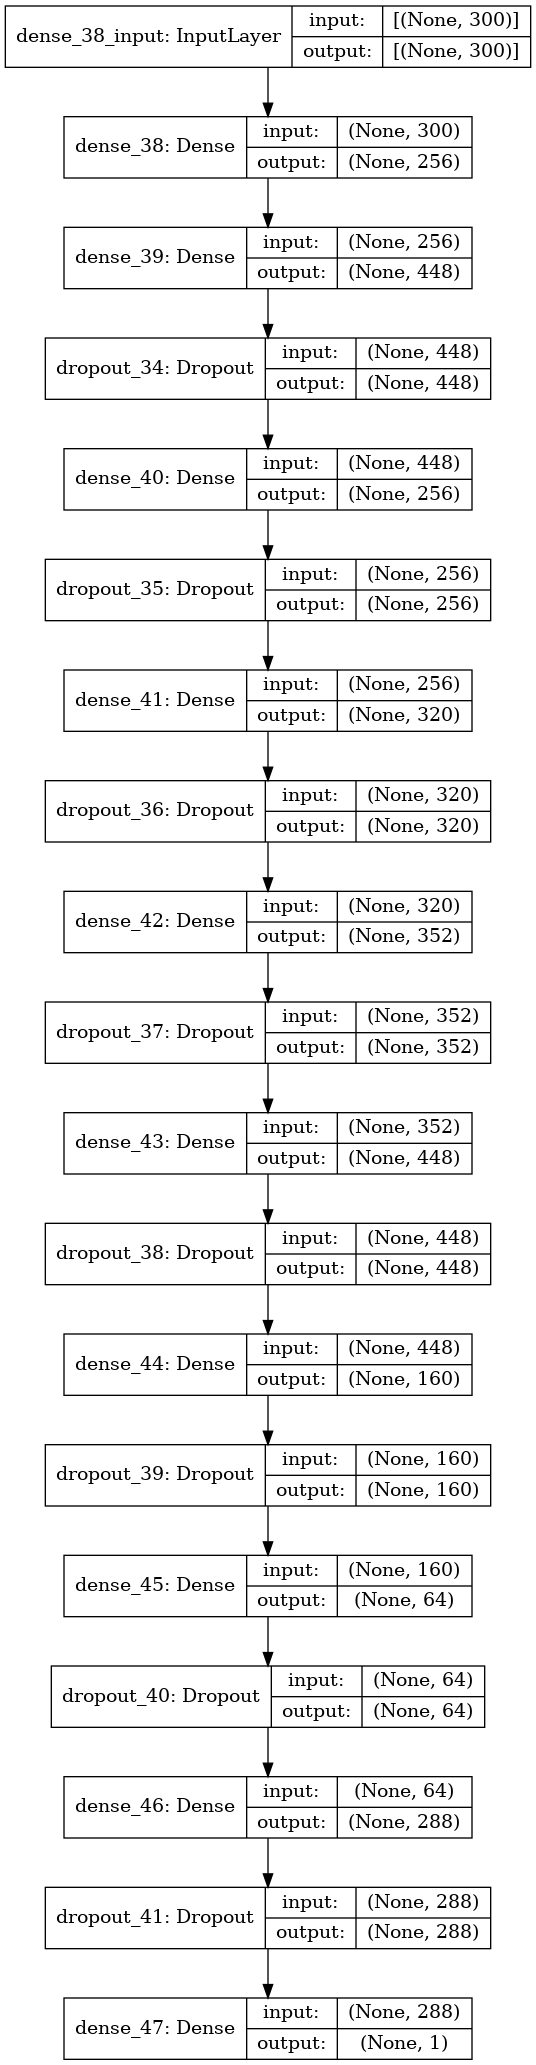

In [25]:
dl_model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"preprocessor.pkl", "wb"))
dl_model.summary()
plot_model(dl_model, show_shapes=True)

# Saving the Lite Model for Deployment

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(dl_model)
dl_lite_model = converter.convert()
with tf.io.gfile.GFile("model.tflite", "wb") as f:
    f.write(dl_lite_model)